(sampler_stats)=
# Sampler Statistics

When checking for convergence or when debugging a badly behaving
sampler, it is often helpful to take a closer look at what the
sampler is doing. For this purpose some samplers export
statistics for each generated sample.

:::{post} May 31, 2022
:tags: diagnostics
:category: beginner
:author: Meenal Jhajharia, Christian Luhmann
:::

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

%matplotlib inline

print(f"Running on PyMC v{pm.__version__}")

WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC v4.0.0b6


In [2]:
az.style.use("arviz-darkgrid")
plt.rcParams["figure.constrained_layout.use"] = False

As a minimal example we sample from a standard normal distribution:

In [3]:
model = pm.Model()
with model:
    mu1 = pm.Normal("mu1", mu=0, sigma=1, shape=10)

In [4]:
with model:
    step = pm.NUTS()
    idata = pm.sample(2000, tune=1000, init=None, step=step, chains=4)

Multiprocess sampling (4 chains in 2 jobs)
NUTS: [mu1]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 10 seconds.


- `Note`: NUTS provides the following statistics( these are internal statistics that the sampler uses, you don't need to do anything with them when using PyMC3, to learn more about them, [check this page](https://docs.pymc.io/api/inference.html#module-pymc3.step_methods.hmc.nuts).

In [5]:
idata.sample_stats

<xarray.Dataset>
Dimensions:             (chain: 4, draw: 2000)
Coordinates:
  * chain               (chain) int64 0 1 2 3
  * draw                (draw) int64 0 1 2 3 4 5 ... 1995 1996 1997 1998 1999
Data variables: (12/13)
    perf_counter_diff   (chain, draw) float64 0.001099 0.0008668 ... 0.0005115
    tree_depth          (chain, draw) int64 2 2 2 2 2 2 2 2 ... 2 2 2 2 2 2 2 2
    acceptance_rate     (chain, draw) float64 0.9408 0.4259 ... 0.9382 0.8286
    step_size           (chain, draw) float64 1.143 1.143 1.143 ... 1.422 1.422
    perf_counter_start  (chain, draw) float64 2.436e+05 2.436e+05 ... 2.436e+05
    step_size_bar       (chain, draw) float64 0.965 0.965 ... 0.9295 0.9295
    ...                  ...
    energy_error        (chain, draw) float64 -0.2584 0.0 ... -0.4669 0.07765
    diverging           (chain, draw) bool False False False ... False False
    energy              (chain, draw) float64 16.84 20.65 17.17 ... 17.08 15.38
    lp                  (chain, draw) float64 -13.04 -13.04 ... -11.49 -11.91
    n_steps             (chain, draw) float64 3.0 3.0 3.0 3.0 ... 3.0 3.0 3.0
    max_energy_error    (chain, draw) float64 -0.2584 1.004 ... -0.4669 0.7978
Attributes:
    created_at:                 2022-05-31T15:32:48.599814
    arviz_version:              0.12.1
    inference_library:          pymc
    inference_library_version:  4.0.0b6
    sampling_time:              10.029414176940918
    tuning_steps:               1000

The sample statistics variables are defined as follows:

- `process_time_diff`: The time it took to draw the sample, as defined by the python standard library time.process_time. This counts all the CPU time, including worker processes in BLAS and OpenMP.

- `step_size`: The current integration step size.

- `diverging`: (boolean) Indicates the presence of leapfrog transitions with large energy deviation from starting and subsequent termination of the trajectory. “large” is defined as `max_energy_error` going over a threshold.

- `lp`: The joint log posterior density for the model (up to an additive constant).

- `energy`: The value of the Hamiltonian energy for the accepted proposal (up to an additive constant).

- `energy_error`: The difference in the Hamiltonian energy between the initial point and the accepted proposal.

- `perf_counter_diff`: The time it took to draw the sample, as defined by the python standard library time.perf_counter (wall time).

- `perf_counter_start`: The value of time.perf_counter at the beginning of the computation of the draw.

- `n_steps`: The number of leapfrog steps computed. It is related to `tree_depth` with `n_steps <= 2^tree_dept`.

- `max_energy_error`: The maximum absolute difference in Hamiltonian energy between the initial point and all possible samples in the proposed tree.

- `acceptance_rate`: The average acceptance probabilities of all possible samples in the proposed tree.

- `step_size_bar`: The current best known step-size. After the tuning samples, the step size is set to this value. This should converge during tuning.

- `tree_depth`: The number of tree doublings in the balanced binary tree.

Some points to `Note`:
- Some of the sample statistics used by NUTS are renamed when converting to `InferenceData` to follow [ArviZ's naming convention](https://arviz-devs.github.io/arviz/schema/schema.html#sample-stats), while some are specific to PyMC3 and keep their internal PyMC3 name in the resulting InferenceData object.
- `InferenceData` also stores additional info like the date, versions used, sampling time and tuning steps as attributes.

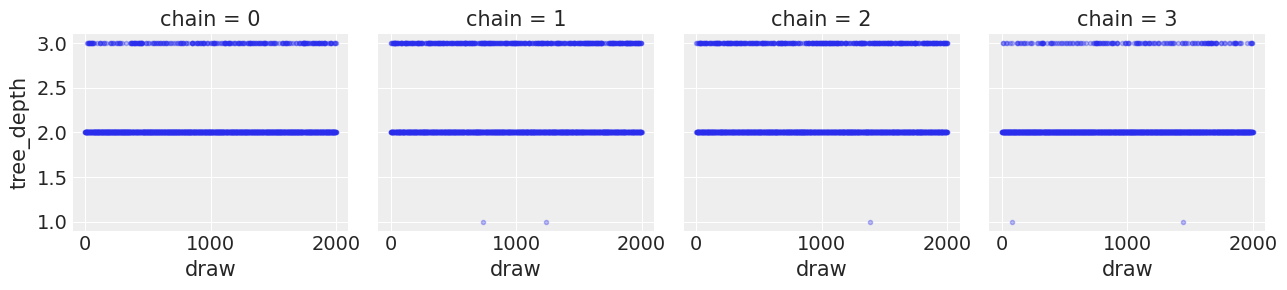

In [6]:
idata.sample_stats["tree_depth"].plot(col="chain", ls="none", marker=".", alpha=0.3);

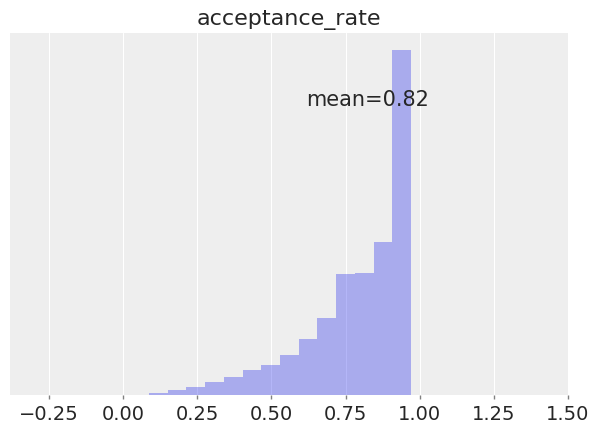

In [7]:
az.plot_posterior(
    idata, group="sample_stats", var_names="acceptance_rate", hdi_prob="hide", kind="hist"
);

We check if there are any divergences, if yes, how many?

In [8]:
idata.sample_stats["diverging"].sum()

<xarray.DataArray 'diverging' ()>
array(0)

In this case no divergences are found. If there are any, check [this notebook](https://github.com/pymc-devs/pymc-examples/blob/main/examples/diagnostics_and_criticism/Diagnosing_biased_Inference_with_Divergences.ipynb) for  information on handling divergences.

It is often useful to compare the overall distribution of the
energy levels with the change of energy between successive samples.
Ideally, they should be very similar:

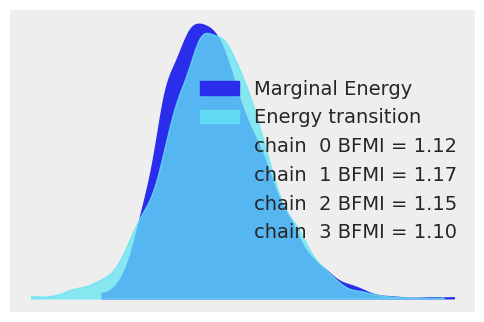

In [9]:
az.plot_energy(idata, figsize=(6, 4));

If the overall distribution of energy levels has longer tails, the efficiency of the sampler will deteriorate quickly.

## Multiple samplers

If multiple samplers are used for the same model (e.g. for continuous and discrete variables), the exported values are merged or stacked along a new axis.

In [10]:
coords = {"step": ["BinaryMetropolis", "Metropolis"], "obs": ["mu1"]}
dims = {"accept": ["step"]}

with pm.Model(coords=coords) as model:
    mu1 = pm.Bernoulli("mu1", p=0.8)
    mu2 = pm.Normal("mu2", mu=0, sigma=1, dims="obs")

In [11]:
with model:
    step1 = pm.BinaryMetropolis([mu1])
    step2 = pm.Metropolis([mu2])
    idata = pm.sample(
        10000,
        init=None,
        step=[step1, step2],
        chains=4,
        tune=1000,
        idata_kwargs={"dims": dims, "coords": coords},
    )

Multiprocess sampling (4 chains in 2 jobs)
CompoundStep
>BinaryMetropolis: [mu1]
>Metropolis: [mu2]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 21 seconds.


In [12]:
list(idata.sample_stats.data_vars)

['p_jump', 'accept', 'scaling', 'accepted']

Both samplers export `accept`, so we get one acceptance probability for each sampler:

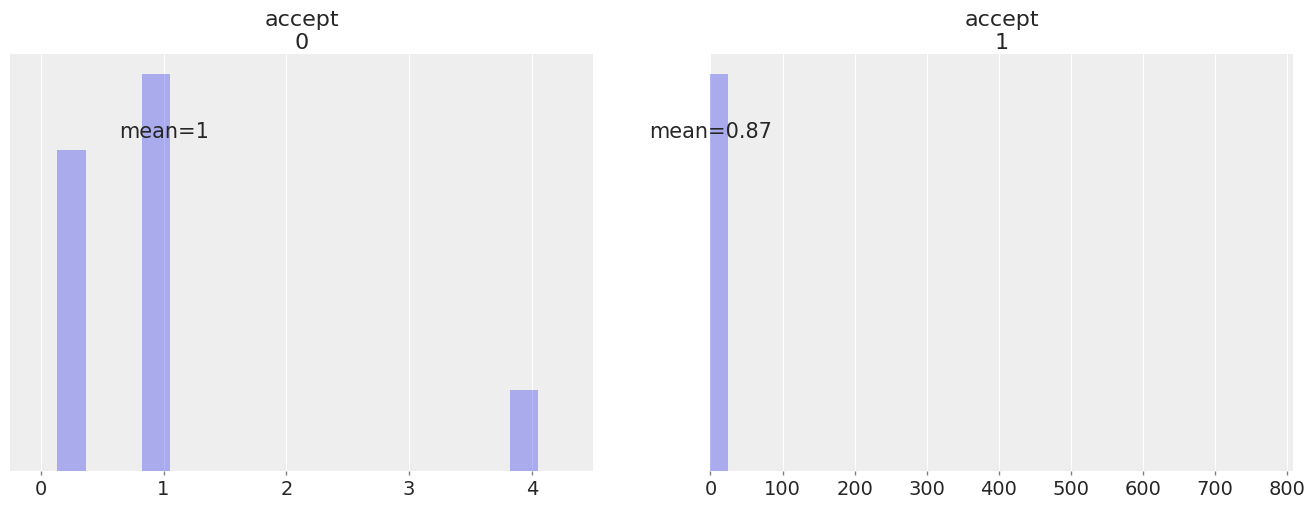

In [13]:
az.plot_posterior(
    idata,
    group="sample_stats",
    var_names="accept",
    hdi_prob="hide",
    kind="hist",
);

We notice that `accept` sometimes takes really high values (jumps from regions of low probability to regions of much higher probability).

In [14]:
# Range of accept values
idata.sample_stats["accept"].max("draw") - idata.sample_stats["accept"].min("draw")

<xarray.DataArray 'accept' (chain: 4, accept_dim_0: 2)>
array([[  3.75      , 102.36028945],
       [  3.75      , 808.01242909],
       [  3.75      , 193.61490756],
       [  3.75      , 473.08420034]])
Coordinates:
  * chain         (chain) int64 0 1 2 3
  * accept_dim_0  (accept_dim_0) int64 0 1

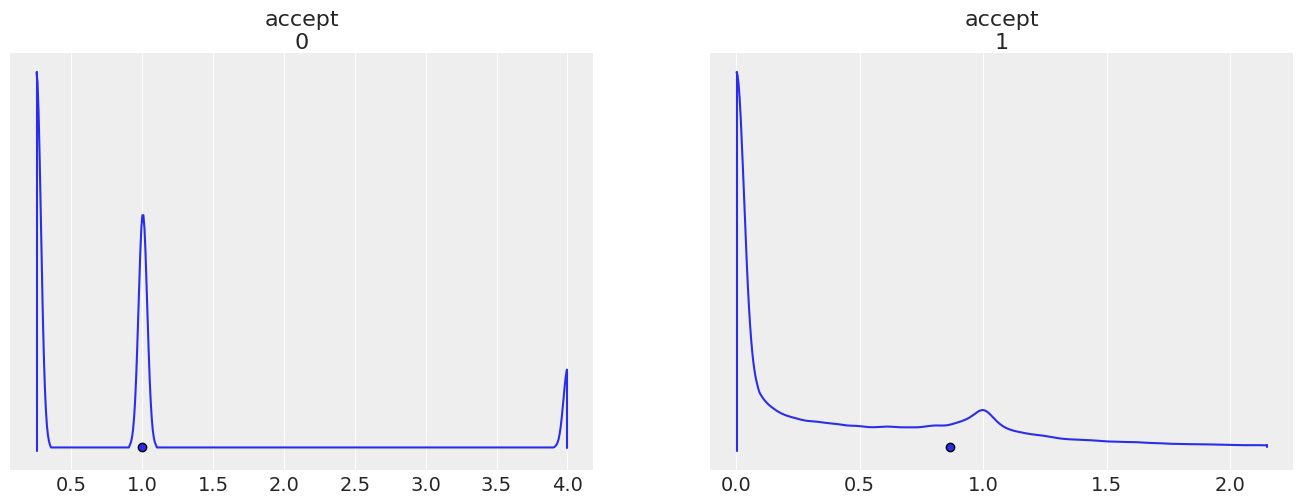

In [15]:
# We can try plotting the density and view the high density intervals to understand the variable better
az.plot_density(
    idata,
    group="sample_stats",
    var_names="accept",
    point_estimate="mean",
);

In [16]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Tue May 31 2022

Python implementation: CPython
Python version       : 3.10.4
IPython version      : 8.4.0

numpy     : 1.23.0rc2
pymc      : 4.0.0b6
arviz     : 0.12.1
pandas    : 1.4.2
matplotlib: 3.5.2

Watermark: 2.3.1



* Updated by Meenal Jhajharia
* Updated by Christian Luhmann

:::{include} ../page_footer.md
:::